In [126]:
import pickle
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegressionCV

from keras.layers import LSTM
from keras.layers import Embedding
from keras.optimizers import RMSprop


from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

from sklearn.metrics import accuracy_score
from keras.layers import Concatenate, Merge

import keras
from keras.utils import to_categorical

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [174]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

In [175]:
y = np.load("y.npy")
X = np.load("X.npy")

In [176]:
X_notes = X.T[:28].T
y_notes = y
X_chords = X.T[56:].T

In [177]:
X_chords.shape

(10204, 28)

In [178]:
X_notes.shape

(10204, 28)

In [179]:
y_notes.shape

(10204,)

In [180]:
X_chords = np.column_stack((X_chords, y_notes.T))
X_chords = X_chords.reshape((-1,1))

In [181]:
chords = np.unique(X_chords)
len(chords)

36

In [182]:
chords_y = np.unique(y)

In [183]:
chords_y

array(['a', 'ad', 'am', 'b', 'bb', 'bbd', 'bm', 'c', 'c#', 'c#d', 'c#m',
       'cd', 'cm', 'd', 'd#d', 'db', 'dm', 'e', 'ea', 'eb', 'ed', 'em',
       'f', 'f#', 'f#m', 'fd', 'fm', 'g', 'gd', 'gm'], dtype='<U32')

In [184]:
coded_y = np.array([])

for note in y_notes:
    for i, chord in enumerate(chords):
        if note == chord:
            coded_y = np.append(coded_y, i)

            
            

In [185]:
coded_X_chords = np.array([])

for x_chord in X_chords:
    for i, chord in enumerate(chords):
        if x_chord == chord:
            coded_X_chords = np.append(coded_X_chords, i)

            
            

In [186]:
X_chords = coded_X_chords.reshape((10204,-1))
y_notes = coded_y

In [187]:
X_notes.shape

(10204, 28)

In [188]:
new_X_notes = []

for notes in X_notes:
    for note in notes:
        new_X_notes.append(int(note) + 1)

In [191]:
X_notes = np.array(new_X_notes)

In [196]:
X_notes = X_notes.reshape((10204,-1))
X_notes.shape

(10204, 28)

In [197]:
X_chords.shape

(10204, 29)

In [199]:
X_1 = X_chords[:8000]
X_1_test = X_chords[8000:]

In [200]:
X_2 = X_notes[:8000]
X_2_test = X_notes[8000:]

In [201]:
y = y_notes[:8000]
y_test = y_notes[8000:]

In [202]:
model_1 = Sequential()
model_1.add(Embedding(37, 20, input_length=29))
model_1.add(LSTM(20))
#model.add(Dense(37, activation='softmax'))
#model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#model.fit(train_X, train_y, epochs=1, batch_size=1, verbose=1, validation_data=(test_X, test_y))#, callbacks=[plot]);

In [203]:
model_2 = Sequential()
model_2.add(Embedding(37, 20, input_length=28))
model_2.add(LSTM(20))
#model.add(Dense(17, activation='softmax'))
#model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#model.fit(X_train_2, y_train_2, epochs=60, verbose=1, validation_data=(X_test_2, y_test_2), callbacks=[plot]);

In [204]:
X_2 = np.array(X_2)

In [205]:
X_2.shape
X_1.shape

(8000, 29)

In [213]:
np.unique(y)

array([ 0.,  2.,  3.,  4.,  5.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       16., 18., 19., 20., 21., 23., 24., 25., 26., 27., 29., 30., 31.,
       34., 35.])

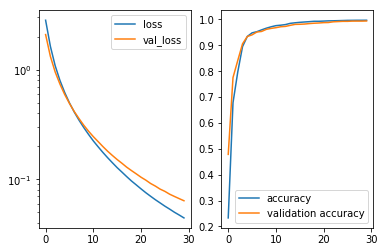

In [215]:
merged_model = Sequential()
merged_model.add(Merge([model_1, model_2], mode="concat"))
merged_model.add(Dense(36, activation='softmax'))
merged_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
merged_model.fit([X_1, X_2], y, batch_size=200, epochs=30, verbose=1, callbacks=[plot], validation_data=[[X_1_test, X_2_test], y_test])